In [87]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainerCallback, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, load_dataset
from copy import deepcopy
import torch

os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

RANDOM_STATE = 42

In [88]:
id2label = {0: "CORRECT", 1: "BUGGY"}
label2id = {"CORRECT": 0, "BUGGY": 1}

In [89]:
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base')

In [90]:
a = 'setDimension width height int x y'
b = 'swap &first &second char* x y'

In [91]:
tokenizer.tokenize(a)

['set', 'Dimension', 'Ġwidth', 'Ġheight', 'Ġint', 'Ġx', 'Ġy']

In [92]:
tokenizer = AutoTokenizer.from_pretrained('dipudl/codet5-base')
# model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
#                                                            num_labels=3,
#                                                            id2label=id2label,
#                                                            label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained('dipudl/codeT5-DistilBERT-wrong-binary-operator-bug-model',
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

In [93]:
tokenizer.tokenize(a)

['set', 'Dim', 'ension', 'Ġwidth', 'Ġheight', 'Ġint', 'Ġx', 'Ġy']

In [94]:
#word = "swap &first &second char* x y"

In [95]:
my_token = tokenizer.tokenize(a)
my_token.insert(0,'Start')
my_token.append('End')
my_token

['Start',
 'set',
 'Dim',
 'ension',
 'Ġwidth',
 'Ġheight',
 'Ġint',
 'Ġx',
 'Ġy',
 'End']

In [96]:
input_ids = torch.tensor(tokenizer(a).input_ids)
input_ids

tensor([    1,   492, 13570,  3722,  2891,  3808,   470,   695,   813,     2])

In [97]:
model.distilbert.embeddings.word_embeddings

Embedding(30522, 768, padding_idx=0)

In [98]:
embedding_vectors_before = model.distilbert.embeddings.word_embeddings(input_ids)

In [99]:
embedding_vectors_before

tensor([[-0.0156, -0.0650, -0.0179,  ..., -0.0331, -0.0566, -0.0254],
        [-0.0170, -0.0533, -0.0213,  ..., -0.0120, -0.0444, -0.0401],
        [-0.0616, -0.0178, -0.0302,  ..., -0.0357, -0.0293, -0.0148],
        ...,
        [-0.0211, -0.0553, -0.0204,  ..., -0.0300, -0.0575, -0.0391],
        [-0.0128, -0.0572, -0.0125,  ..., -0.0277, -0.0525, -0.0308],
        [-0.0228, -0.0701, -0.0080,  ..., -0.0318, -0.0715, -0.0258]],
       grad_fn=<EmbeddingBackward0>)

In [100]:
embedding_vectors_before.shape

torch.Size([10, 768])

In [101]:
positional_encoding = model.distilbert.embeddings.position_embeddings(torch.tensor(range(len(input_ids))))

In [102]:
positional_encoding

tensor([[ 1.4731e-02, -2.3781e-02, -3.8251e-02,  ..., -1.0680e-02,
         -1.2616e-03,  1.5584e-02],
        [-6.2504e-04,  7.2108e-03, -1.7768e-02,  ...,  2.2016e-02,
          2.5742e-02, -5.0380e-03],
        [-1.0828e-02, -2.9227e-04, -9.0180e-03,  ...,  1.3672e-02,
          1.4553e-02, -1.3919e-02],
        ...,
        [ 1.1038e-04, -9.9432e-03, -5.3007e-03,  ..., -6.2991e-04,
          1.6049e-02,  2.3451e-03],
        [ 3.7319e-04, -1.2221e-02, -1.5817e-02,  ...,  1.5544e-02,
          1.2627e-02,  4.2718e-03],
        [ 6.1085e-03, -2.6334e-03, -1.4536e-02,  ...,  2.1069e-02,
         -2.6085e-05,  4.0873e-03]], grad_fn=<EmbeddingBackward0>)

In [103]:
positional_encoding.shape

torch.Size([10, 768])

In [104]:
final_embedding_vectors = model.distilbert.embeddings.LayerNorm(0.9 * embedding_vectors_before + 0.1 * positional_encoding)

In [105]:
final_embedding_vectors.shape

torch.Size([10, 768])

In [106]:
final_embedding_vectors

tensor([[ 0.2408, -0.6792,  0.1108,  ..., -0.2514, -0.5733, -0.0571],
        [ 0.1915, -0.4417,  0.0954,  ...,  0.1202, -0.3246, -0.4156],
        [-0.4101,  0.4758,  0.2190,  ..., -0.0252,  0.2059,  0.4225],
        ...,
        [ 0.1172, -0.5053,  0.1390,  ..., -0.1887, -0.5760, -0.3693],
        [ 0.2721, -0.5572,  0.2448,  ..., -0.1350, -0.5042, -0.2015],
        [ 0.0926, -0.7528,  0.3252,  ..., -0.1825, -0.8538, -0.0894]],
       grad_fn=<NativeLayerNormBackward0>)

In [107]:
drop_out_vectors = model.distilbert.embeddings.dropout(final_embedding_vectors)

In [108]:
drop_out_final = model.distilbert.transformer.layer[0].attention.dropout(drop_out_vectors)
drop_out_final

tensor([[ 0.2408, -0.6792,  0.1108,  ..., -0.2514, -0.5733, -0.0571],
        [ 0.1915, -0.4417,  0.0954,  ...,  0.1202, -0.3246, -0.4156],
        [-0.4101,  0.4758,  0.2190,  ..., -0.0252,  0.2059,  0.4225],
        ...,
        [ 0.1172, -0.5053,  0.1390,  ..., -0.1887, -0.5760, -0.3693],
        [ 0.2721, -0.5572,  0.2448,  ..., -0.1350, -0.5042, -0.2015],
        [ 0.0926, -0.7528,  0.3252,  ..., -0.1825, -0.8538, -0.0894]],
       grad_fn=<NativeLayerNormBackward0>)

In [109]:
drop_out_final.shape

torch.Size([10, 768])

In [110]:
query = model.distilbert.transformer.layer[0].attention.q_lin(drop_out_final)
key = model.distilbert.transformer.layer[0].attention.k_lin(drop_out_final)
values = model.distilbert.transformer.layer[0].attention.v_lin(drop_out_final)

In [111]:
query

tensor([[-0.2172,  0.2293,  0.4491,  ..., -2.4213, -0.7798,  0.9900],
        [ 0.1515,  0.2009,  0.2343,  ..., -2.6056, -0.7436,  0.1482],
        [-0.3972,  0.6620,  0.1107,  ..., -0.1784, -0.2014,  0.8256],
        ...,
        [ 0.1960,  0.1711,  0.1628,  ..., -2.1963, -0.9803,  0.2606],
        [ 0.1662,  0.2199,  0.3928,  ..., -2.2737, -0.7834,  0.3770],
        [-0.0541,  0.1729,  0.3899,  ..., -1.9409, -0.7215,  0.8775]],
       grad_fn=<AddmmBackward0>)

In [112]:
key 

tensor([[-4.7661e-01,  7.8204e-01, -2.9188e-01,  ...,  1.0133e-01,
          9.4533e-01,  3.2119e+00],
        [-4.0801e-01,  6.5106e-01, -2.5006e-01,  ..., -1.1481e-01,
          6.7938e-01,  1.9859e+00],
        [-7.3047e-01,  7.6058e-03,  2.3339e-02,  ..., -9.4584e-01,
          1.5217e+00,  1.5124e+00],
        ...,
        [-5.2287e-01,  8.6244e-01,  3.2307e-02,  ..., -1.8529e-01,
          7.2268e-01,  1.9896e+00],
        [-7.1763e-01,  7.9533e-01, -1.0936e-01,  ...,  3.1700e-03,
          7.8592e-01,  2.2292e+00],
        [-6.3108e-01,  7.0572e-01, -5.1614e-01,  ...,  2.4247e-01,
          1.4665e+00,  3.0169e+00]], grad_fn=<AddmmBackward0>)

In [113]:
values

tensor([[ 0.3440,  0.3317, -0.3714,  ...,  0.0692,  0.4051,  0.1301],
        [ 0.1091,  0.0189, -0.2638,  ...,  0.1076,  0.5115, -0.2289],
        [-0.5627,  1.0878, -0.9090,  ..., -0.2838, -0.5766, -0.7924],
        ...,
        [-0.0087, -0.1040, -0.0854,  ..., -0.0308,  0.2158,  0.1188],
        [-0.0247, -0.0227, -0.0027,  ...,  0.1139,  0.2509,  0.0445],
        [ 0.4120,  0.1782,  0.2826,  ...,  0.5687,  0.2055,  0.4816]],
       grad_fn=<AddmmBackward0>)

In [114]:
query.shape

torch.Size([10, 768])

In [116]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [115]:
model.distilbert.transformer.layer[1]

TransformerBlock(
  (attention): MultiHeadSelfAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin): Linear(in_features=768, out_features=768, bias=True)
    (out_lin): Linear(in_features=768, out_features=768, bias=True)
  )
  (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (ffn): FFN(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=768, out_features=3072, bias=True)
    (lin2): Linear(in_features=3072, out_features=768, bias=True)
    (activation): GELUActivation()
  )
  (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)

In [76]:
model.distilbert.transformer.layer[1]

TransformerBlock(
  (attention): MultiHeadSelfAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin): Linear(in_features=768, out_features=768, bias=True)
    (out_lin): Linear(in_features=768, out_features=768, bias=True)
  )
  (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (ffn): FFN(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=768, out_features=3072, bias=True)
    (lin2): Linear(in_features=3072, out_features=768, bias=True)
    (activation): GELUActivation()
  )
  (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)

In [77]:
query.shape

torch.Size([10, 768])

In [78]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Define the softmax function for the attention scores
softmax = torch.nn.Softmax(dim=-1)

# Define the input query, key, and values
batch_size = 1
seq_len = query.shape[0]
query_hidden_size = query.shape[1]
key_hidden_size = key.shape[1]
values_hidden_size = values.shape[1]


# Define the number of heads and the head size
num_heads = 8
head_size = values_hidden_size // num_heads
dk = query.shape[-1]

# Define the linear layers for projection
query_proj = torch.nn.Linear(query_hidden_size, values_hidden_size)
key_proj = torch.nn.Linear(key_hidden_size, values_hidden_size)
value_proj = torch.nn.Linear(values_hidden_size, values_hidden_size)
output_proj = torch.nn.Linear(values_hidden_size, values_hidden_size)

# Split the query, key, and values into multiple heads
query_heads = query_proj(query).view(batch_size, seq_len, num_heads, head_size).transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_size)
key_heads = key_proj(key).view(batch_size, seq_len, num_heads, head_size).transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_size)
value_heads = value_proj(values).view(batch_size, seq_len, num_heads, head_size).transpose(1, 2)  # shape: (batch_size, num_heads, seq_len, head_size)

# Calculate the attention scores for each head
attention_scores = torch.matmul(query_heads, key_heads.transpose(-2, -1))  # shape: (batch_size, num_heads, seq_len, seq_len)

# Apply the softmax function to get the attention weights for each head

my_attention_weights = softmax(attention_scores)


attention_weights = torch.softmax(attention_scores/torch.sqrt(torch.tensor(dk).float()), dim=-1)  # shape: (batch_size, num_heads, seq_len, seq_len)

# Calculate the context vectors for each head
context_vectors = torch.matmul(attention_weights, value_heads)  # shape: (batch_size, num_heads, seq_len, head_size)

# Concatenate the context vectors for each head along the last dimension
multihead_output = context_vectors.transpose(1, 2).contiguous().view(1, seq_len, values_hidden_size)

# Project the output through a linear layer
output = output_proj(multihead_output)  # shape: (batch_size, seq_len, values_hidden_size)

In [79]:
my_attention_weights.squeeze()[1].detach().numpy()

array([[1.40748415e-02, 2.59537320e-03, 2.06024572e-03, 9.02834594e-01,
        6.28013164e-02, 6.81602862e-03, 1.61236245e-03, 4.18834446e-04,
        1.62163586e-03, 5.16475085e-03],
       [2.21595205e-02, 5.79338288e-03, 1.43735493e-02, 8.19340765e-01,
        1.17567509e-01, 6.90831710e-03, 2.40595057e-03, 1.28768058e-03,
        3.36275343e-03, 6.80057798e-03],
       [1.50482118e-01, 1.54251784e-01, 1.34719448e-04, 4.68554348e-02,
        3.61450687e-02, 4.63919491e-01, 7.97823668e-02, 3.14836092e-02,
        2.27678865e-02, 1.41774872e-02],
       [1.32956445e-01, 2.53276348e-01, 3.56706069e-03, 5.46324719e-03,
        5.32057472e-02, 1.75305121e-02, 2.66418383e-02, 3.93825084e-01,
        9.81364474e-02, 1.53973149e-02],
       [1.14852734e-01, 6.15362264e-02, 1.77386273e-02, 2.90041894e-01,
        3.62372361e-02, 2.80006707e-01, 4.17416804e-02, 1.09218927e-02,
        4.18697111e-02, 1.05053194e-01],
       [1.73383311e-03, 6.78699755e-04, 1.61115348e-03, 9.91895616e-01,
   

In [80]:
attention_weights.squeeze()[1].detach().numpy()

array([[0.10245267, 0.09638925, 0.09558947, 0.1190512 , 0.1081337 ,
        0.09980675, 0.09474768, 0.09024935, 0.09476729, 0.09881261],
       [0.10188293, 0.09706835, 0.10030387, 0.11605886, 0.10820635,
        0.09768681, 0.09403861, 0.09194117, 0.09518164, 0.09763142],
       [0.10523959, 0.10533359, 0.08169433, 0.10090072, 0.09996021,
        0.10960311, 0.10285728, 0.09946342, 0.09830692, 0.09664083],
       [0.10430586, 0.10675991, 0.09153891, 0.09295792, 0.1009151 ,
        0.09695216, 0.09842753, 0.10847406, 0.10316917, 0.0964993 ],
       [0.10222626, 0.0999501 , 0.09556305, 0.1057012 , 0.09805837,
        0.10556698, 0.09856003, 0.09390525, 0.09857092, 0.10189781],
       [0.10085111, 0.09749503, 0.10058442, 0.1268183 , 0.09082408,
        0.09923081, 0.09603676, 0.09019777, 0.0970749 , 0.10088683],
       [0.10026547, 0.09538577, 0.09267195, 0.11873978, 0.10521853,
        0.1001261 , 0.09791771, 0.09323127, 0.09698269, 0.09946067],
       [0.10150699, 0.09551605, 0.0968891

In [81]:
attention_weights.squeeze()[1].detach().numpy().shape

(10, 10)

In [82]:
output

tensor([[[ 0.0608,  0.0209,  0.0156,  ...,  0.2696,  0.0738, -0.0092],
         [ 0.0618,  0.0233,  0.0189,  ...,  0.2699,  0.0743, -0.0108],
         [ 0.0550,  0.0214,  0.0248,  ...,  0.2749,  0.0839, -0.0161],
         ...,
         [ 0.0602,  0.0229,  0.0173,  ...,  0.2684,  0.0746, -0.0116],
         [ 0.0610,  0.0213,  0.0177,  ...,  0.2696,  0.0753, -0.0106],
         [ 0.0579,  0.0192,  0.0129,  ...,  0.2683,  0.0766, -0.0059]]],
       grad_fn=<ViewBackward0>)

In [83]:
output.shape

torch.Size([1, 10, 768])

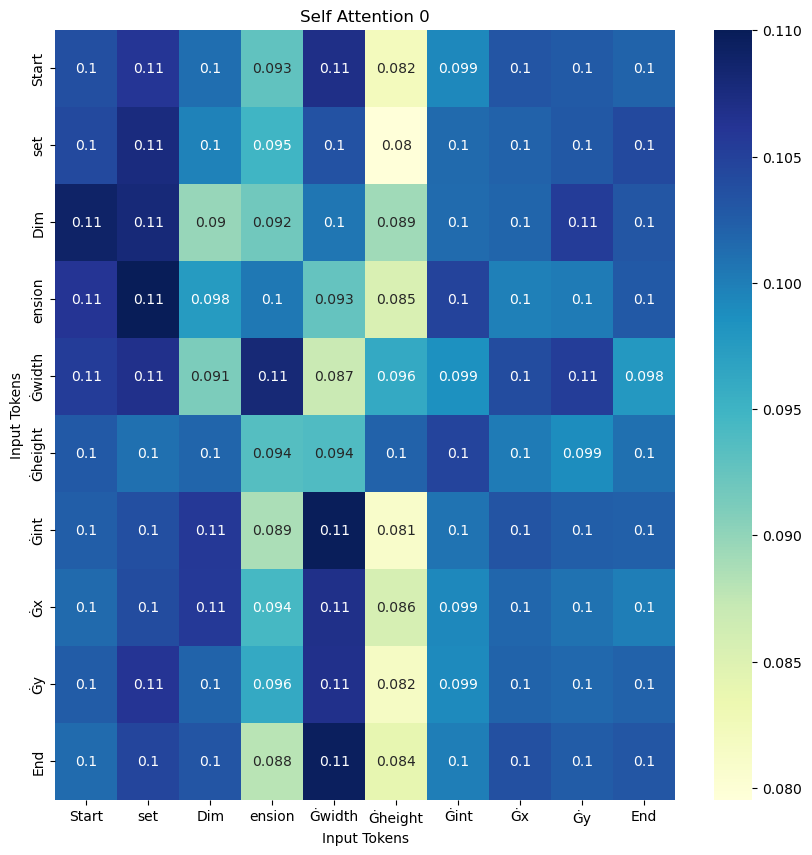

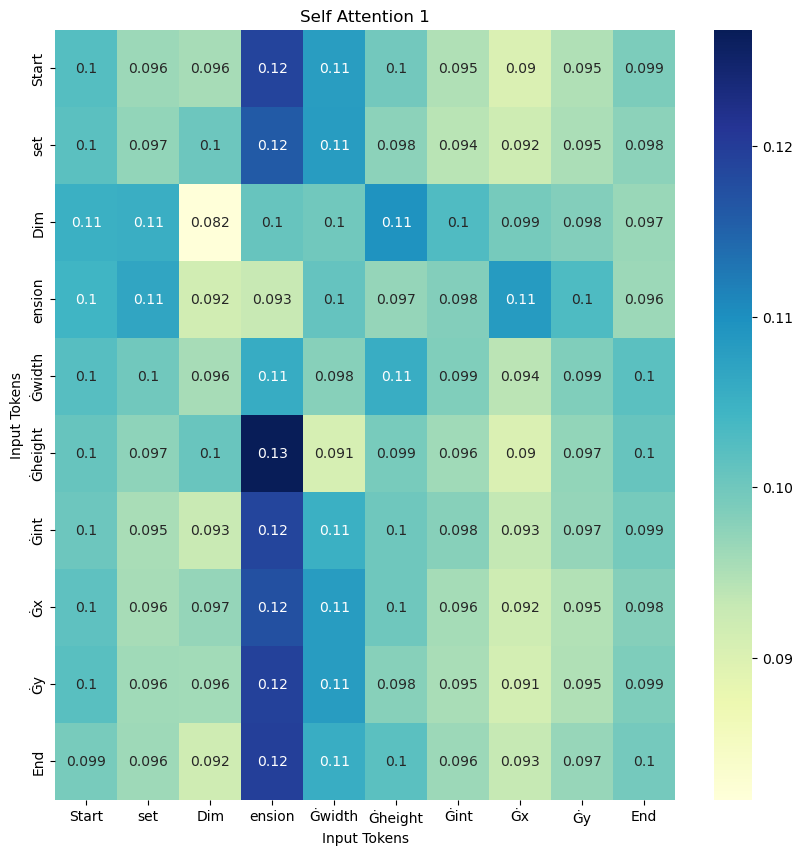

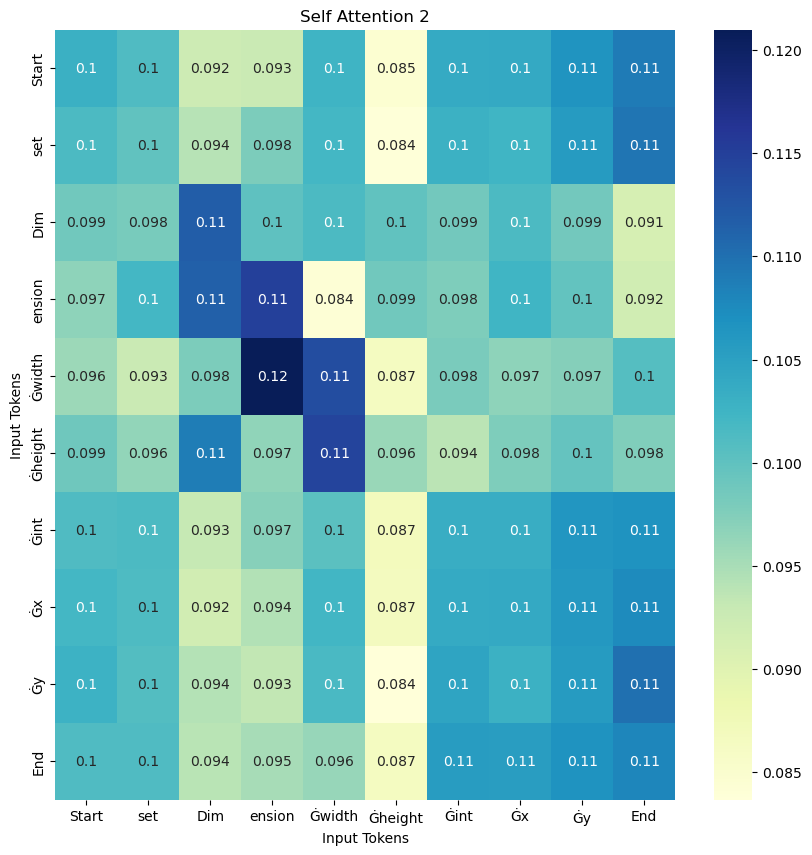

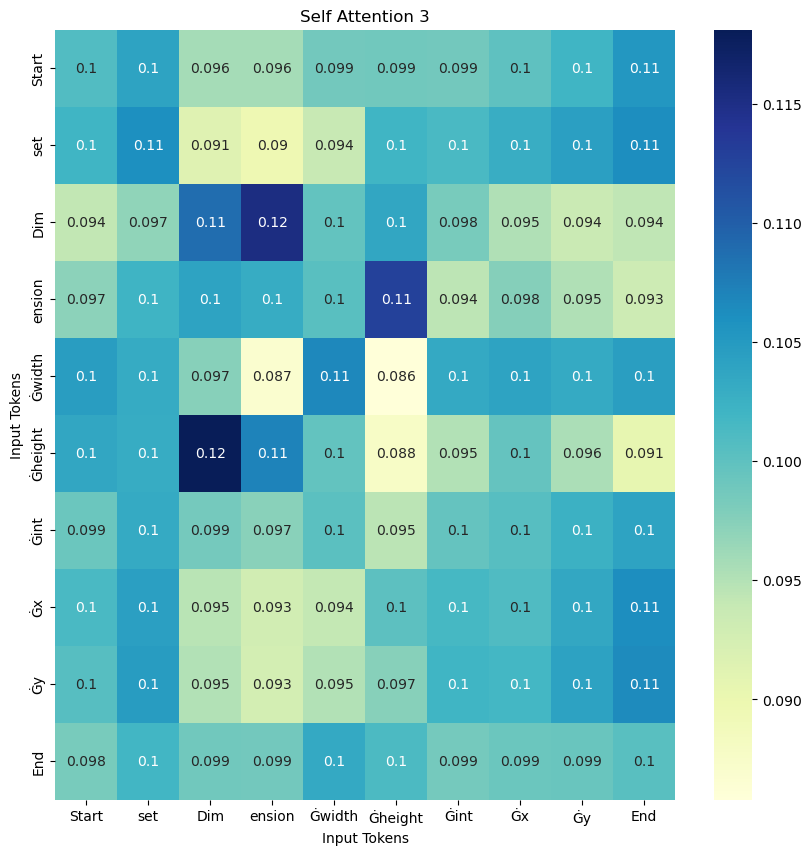

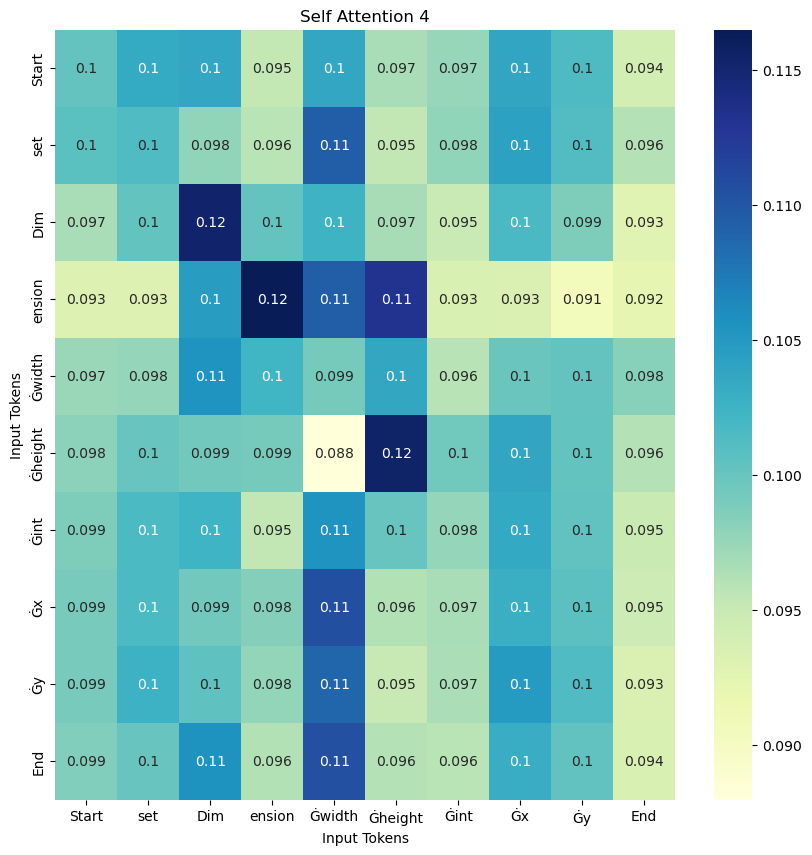

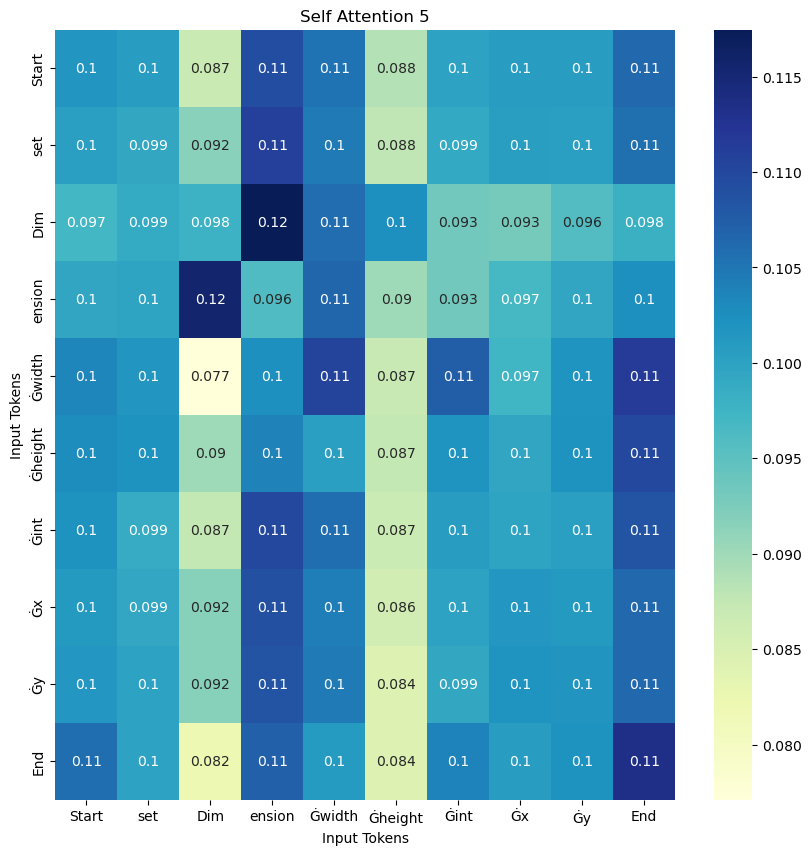

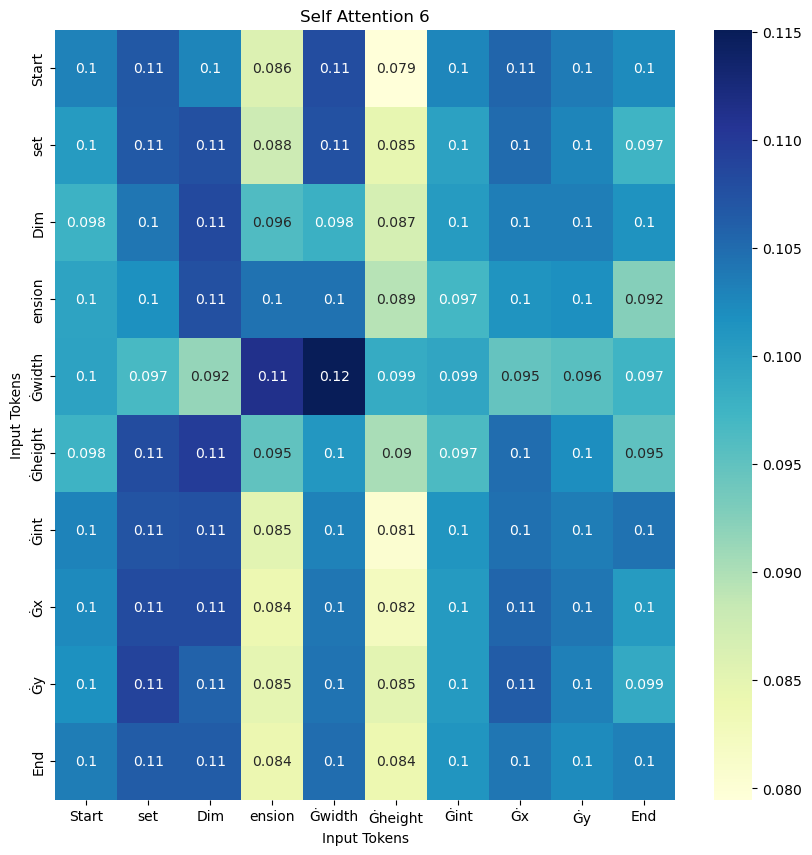

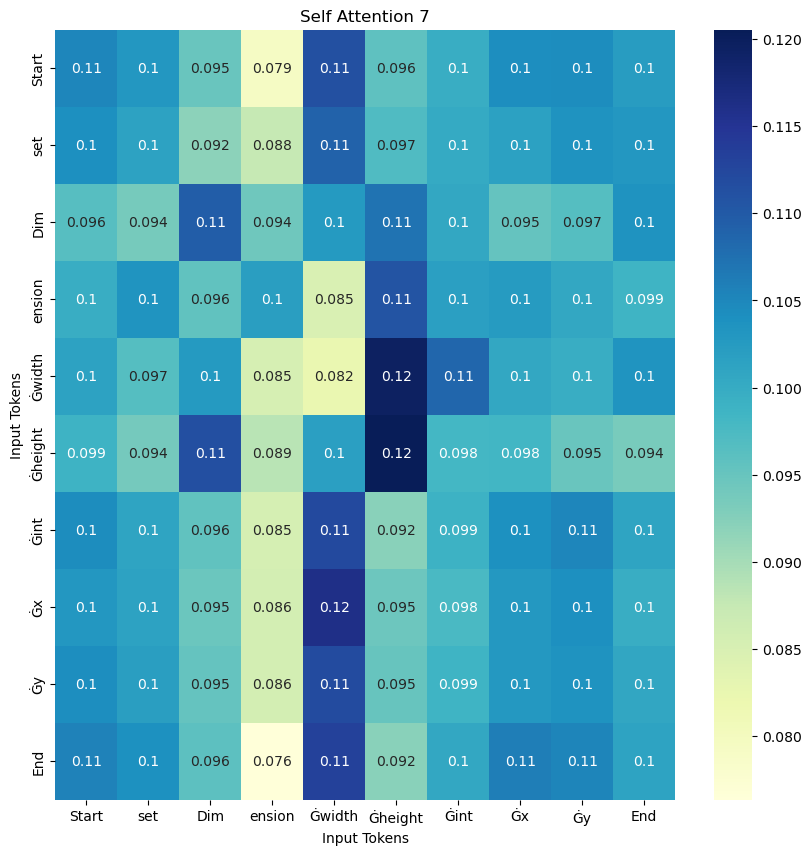

In [84]:
for i in range(attention_weights.squeeze().detach().numpy().shape[0]):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(attention_weights.squeeze()[i].detach().numpy(), cmap='YlGnBu', annot=True, ax=ax,xticklabels=my_token, yticklabels=my_token)
    ax.set_title(f'Self Attention {i}')
    ax.set_xlabel("Input Tokens")
    ax.set_ylabel("Input Tokens")
    plt.show()

In [85]:
import numpy as np
import matplotlib.pyplot as plt

In [86]:
plt.rcParams['font.family'] = 'Times New Roman'

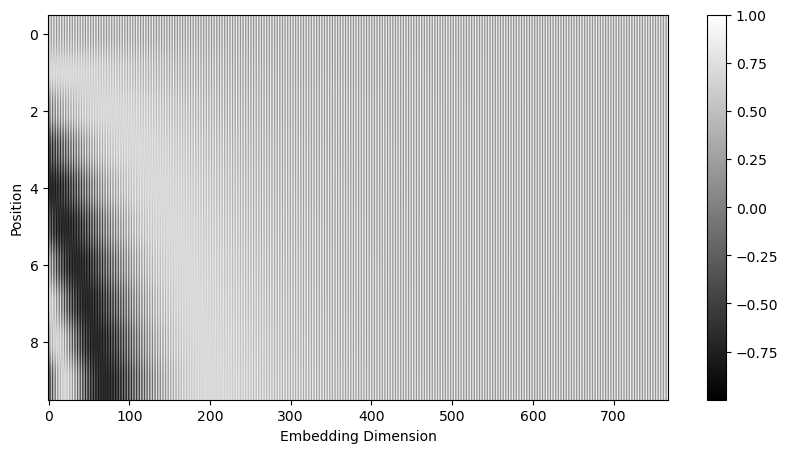

In [6]:
pos = np.arange(10)
d = 768
pe = np.zeros((len(pos), d))

for i in range(d // 2):
    pe[:, 2*i] = np.sin(pos / 10000**(2*i / d))
    pe[:, 2*i+1] = np.cos(pos / 10000**(2*i / d))

plt.figure(figsize=(10, 5))
plt.imshow(pe, cmap='gray', aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')

plt.colorbar()
plt.show()

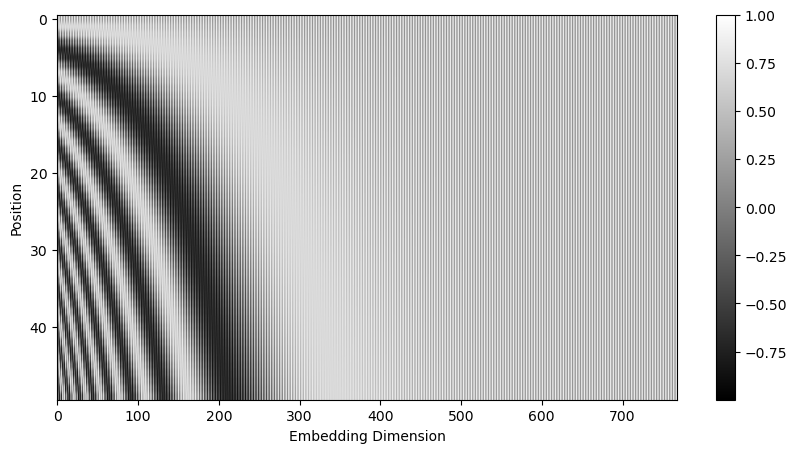

In [7]:
pos = np.arange(50)
d = 768
pe = np.zeros((len(pos), d))

for i in range(d // 2):
    pe[:, 2*i] = np.sin(pos / 10000**(2*i / d))
    pe[:, 2*i+1] = np.cos(pos / 10000**(2*i / d))

plt.figure(figsize=(10, 5))
plt.imshow(pe, cmap='gray', aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.show()

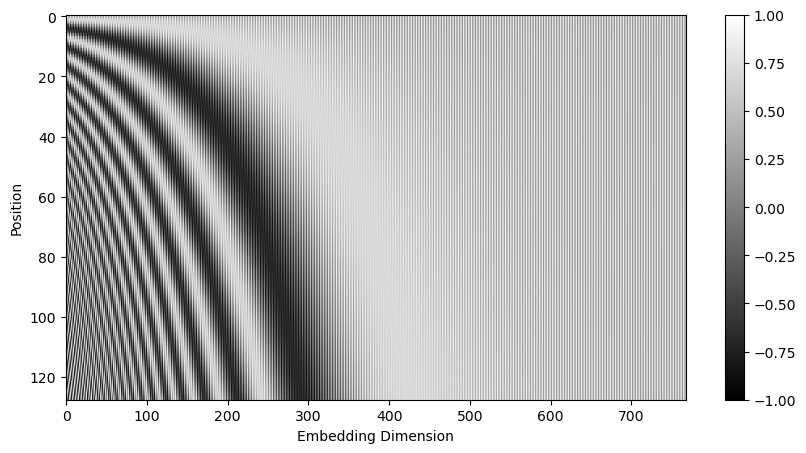

In [8]:
pos = np.arange(128)
d = 768
pe = np.zeros((len(pos), d))

for i in range(d // 2):
    pe[:, 2*i] = np.sin(pos / 10000**(2*i / d))
    pe[:, 2*i+1] = np.cos(pos / 10000**(2*i / d))

plt.figure(figsize=(10, 5))
plt.imshow(pe, cmap='gray', aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.show()